# Proyecto Final Área de Imágenes
### EL5206 Laboratorio de Inteligencia Computacional y Robótica

Integrantes:
* José Díaz
* Luis Jiménez

El proyecto a realizar consiste en el desarrollo e implementación de un
algoritmo de búsqueda de imágenes del tipo CBIR, el cual hará comparaciones entre
una imagen de consulta e imágenes en la base de datos *INRIA Holidays dataset* a través de sus vectores de características.
Para esta implementación se utilizarán dos extractores: uno clásico (HOG) y otro
basado en redes convolucionales (CNN).

Nota: con el fin de que el código funcione, todas las imágenes de la base de datos se almacenan
en la carpeta JPG, que está en el mismo directorio que este notebook Jupyter.

### Librerías útiles

Carga de librerías útiles para el desarrollo del proyecto.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import transforms
import os
from tqdm.notebook import tqdm
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.image as mpimg

### 1. Extracción de características

Para la extracción de carecterísticas se utilizará la función *feature_extractor*,
que extrae el vector de características de una imagen, utilizando el extractor
de tipo HOG  (clásico) o tipo CNN (red neuronal).

Los parámetros que se le entregan a la función son el directorio de
la imagen o imágenes (*path_list*), un directorio de guardado (*save_path*)
y el tipo de extractor (*extractor_type*). Cada vector de características
asociado a una imagen se guarda en el directorio de guardado en forma de un
archivo binario de formato *.npy*, el cual puede ser recuperado como array de Numpy
mediante la función *np.load*.

Hay que precisar que los directorios donde se guardarán los vectores de
características deben estar ya creados para que el código funcione, por lo
que en el mismo directorio de este notebook se requieren 2 carpetas: *jpg_hog* para
los vectores extraídos con el método HOG, y *jpg_cnn* para la extracción
con CNN.

In [2]:
def feature_extractor(path_list, save_path, extractor_type):

    if type(path_list) != type([]):
        path_list = [path_list]

    if extractor_type == 'HOG':

        for file in tqdm(path_list):
            image = Image.open(file)
            image = image.resize((224,224))

            hog_vect = hog(image, orientations=16, pixels_per_cell=(8, 8),
                            cells_per_block=(1, 1), feature_vector=True, multichannel=True)

            vect_name = vect_name = os.path.join(save_path, 'hog_' + os.path.basename(file[:-4]))
            #print(type(hog_vect))
            #print(hog_vect.shape)
            np.save(vect_name, hog_vect)


    elif extractor_type == 'CNN':

        model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
        model = torch.nn.Sequential(*(list(model.children())[:-1]))

        preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
         # create a mini-batch as expected by the model


        # move the input and model to GPU for speed if available
        if torch.cuda.is_available():
            input_batch = input_batch.to('cuda')
            model.to('cuda')

        with torch.no_grad():
            for file in tqdm(path_list):
                image = Image.open(file)
                image = image.resize((224,224))
                input_tensor = preprocess(image)
                input_batch = input_tensor.unsqueeze(0)

                output = model(input_batch)
                output = output.numpy().ravel()
                vect_name = os.path.join(save_path, 'cnn_' + os.path.basename(file[:-4]))
                #print(type(hog_vect))
                #print(hog_vect.shape)
                np.save(vect_name, output)

    else:
        print('Unknown extractor, please use either "HOB" or "CNN"')

#### Lista de directorios de todas las imágenes de la BBDD

In [4]:
file_paths = [os.path.join('jpg', file) for file in os.listdir('jpg')]

#### Extracción usando HOG

Basta con correr una sola vez la celda para generar los archivos.

In [6]:
feature_extractor(file_paths, 'jpg_hog/', 'HOG')

#### Extracción usando CNN

Nota: por el momento, esta extracción solo funciona en Google Colab.
Se ha utilizado PyCharm con entorno local pero el código se cae. Para
efectos de prueba en PyCharm, este código se ha ejecutado en Colab para
obtener los archivos asociados a los vectores de características.

In [6]:
#feature_extractor(file_paths, 'jpg_cnn/', 'CNN')

### 2. Métricas

Se definen métricas de comparación entre vectores de
características de imágenes, correspondientes a distancia entre
vectores.

#### Distancia euclideana

In [3]:
def dist_euc(X, Y):

    dist = np.linalg.norm(X-Y)
    return dist

#### Distancia chi-cuadrado [1]

In [4]:
def dist_chi2(X, Y):

    chi = 0.5 * np.sum([((x - y) ** 2) / (x + y)
                      for (x, y) in zip(X, Y)])
    return chi

##### Pruebas de dist_euc y dist_chi2

In [15]:
X = np.array([1,2,3])
Y = np.array([5,6,7])
print(dist_euc(X, Y), dist_chi2(X, Y))

6.928203230275509 3.133333333333333 Power_divergenceResult(statistic=8.152380952380952, pvalue=0.016971997886164398)


#### Función para elegir tipo de distancia

In [5]:
def dist_vectors(X, Y, dist_type):

    if dist_type == 'euc':

        dist = dist_euc(X, Y)

    elif dist_type == 'chi2':

        dist = dist_chi2(X, Y)

    return dist

### 3. Comparación de una imagen de consulta con la BBDD

En esta sección, para cada imagen de consulta, se calcula la distancia entre
su vector de características con todos los vectores de características de
la base de datos.

#### Separación entre grupo de consulta y grupo de BBDD

Los nombres de los archivos de las imágenes, obviando la extensión,
se construyen mediante la siguiente estructura:

1 + *CLASE* + *ID_imagen*

donde *CLASE* es la clase de la imagen, codificada en 3 dígitos, e
*ID_imagen*, codificado en 2 dígitos, que permite distinguir si una
imagen es de consulta o de la BBDD. Para este caso, todas las imágenes
con *ID_imagen = '00'* corresponden a imágenes de consulta. Las imágenes
que no cumplan esa condición corresponden a la BBDD.

Existen parámetros y variables de importancia tanto en en esta sección
como para desarrollos posteriores:

*   *ex_type* es un string que permite decidir qué tipo de extractor fue
    el usado para los vectores de características, y por ende, para
    elegir la carpeta en cuestión donde dichos vectores están almacenados. Puede
    setearse como *'hog*, para el extractor clásico, o como *'cnn'* para el extractor
    CNN.
*   *img_query* es una lista que guarda en cada componente un vector de
    características asociado a una imagen de consulta.
*   *query_names* es una lista que guarda en cada componente un string
    con el nombre de una imagen de consulta, en la misma posición en que
    su vector de características de guardó en *img_query*. Ej: si el vector
    se ubica en *img_query[2]*, el nombre de dicha imagen se ubica en
    *query_names[2]*.

De manera análoga se definen:
*   *img_db*, que guarda los vectores asociados a las imágenes de la BBDD.
*   *db_names*, que guarda strings de los nombres de dichas imágenes.

In [6]:
ex_type = 'hog'
w_path = 'jpg_' + ex_type + '/'
img_query = []
query_names = []
img_db = []
db_names = []

In [7]:
for file in tqdm(os.listdir(w_path)):

    vector_path = w_path + file
    feat_vector = np.load(vector_path)
    ID_image = vector_path[-6:-4] #extracción del ID

    if ID_image == '00': #comprobar si la img es de consulta
        img_query.append(feat_vector)
        query_names.append(file[-10:-4]) #guardar nombre de imagen

    else:
        img_db.append(feat_vector)
        db_names.append(file[-10:-4])

#### Cálculo de distancias entre imagen de consulta e imágenes de la BBDD

Una vez separados los vectores, se realiza lo siguiente: para cada vector de
consulta, se calcula la distancia entre este y cada vector de la BBDD, generando
un vector de distancias. Para conservar estas distancias obtenidas, se ha generado
un diccionario de nombre *distances_euc* para distancias calculadas usando
 distancia euclideana, y un diccionario llamado *distances_chi2* para
 distancias calculadas mediante distancia chi cuadrado.
Para ambos diccionarios, la sintaxis se utiliza como:

*distances_X{'query_name'} = distances*

donde *'query_name'* es el nombre asociado a la imagen de consulta (los nombres
de estas imágenes están almacenados en la lista *query_names*) y *distances* es su
vector de características asociado (los cuales se obtienen de la lista *img_query*).


In [8]:
#distancia euclideana
distances_euc = {}
for i in range(len(img_query)):

    query_vect = img_query[i]
    query_name = query_names[i]
    distances = []

    for j in range(len(img_db)):

        distances.append(dist_vectors(query_vect, img_db[j],
                                      dist_type = 'euc'))

    distances_euc[query_name] = np.array(distances)

In [16]:
#distancia chi2
distances_chi2 = {}
for i in range(len(img_query)):

    query_vect = img_query[i]
    query_name = query_names[i]
    distances = []

    for j in range(len(img_db)):

        distances.append(dist_vectors(query_vect, img_db[j],
                                      dist_type = 'chi2'))

    distances_chi2[query_name] = np.array(distances)

<ipython-input-12-18cc7abf22ff>:3: RuntimeWarning: invalid value encountered in double_scalars
  chi = 0.5 * np.sum([((x - y) ** 2) / (x + y)


KeyboardInterrupt: 

### 4. Ordenamiento de imágenes por relevancia (medida de Ranking)

A continuación, para cada imagen de consulta, se ordenan de menor a mayor
las distancias obtenidas al hacer la comparación con la base de datos.
Adicionalmente, se conservan los índices de las distancias previo al
ordenamiento, ya que dichos índices corresponden a las imágenes de la
base de datos, que se necesitarán para la medida de ranking. Lo anterior
implica la generación de dos diccionarios nuevos: *dist_sort_X*, que
funciona como los diccionarios *distances_X*, con el vector de distancias
ordenado de menor a mayor valor, y el diccionario
*dist_sort_X_index*, que guarda las posiciones de las distancias de
menor a mayor, utilizando los índices previos al ordenamiento.

La sintaxis de ambos diccionarios es como sigue:

*   *dist_sort_X{'nombre_img_consulta'} = vector_distancias*
*   *dist_sort_X_index{'nombre_img_consulta'} = pos_previas_dist*

Como se puede apreciar, la forma de la sintaxis es análoga a los diccionarios
que tienen sus distancias sin ordenar. De igual forma, se tienen 2 versiones
asociadas a el tipo de distancia asociada (de ahí la *X*).

In [9]:
#distancia euclideana
dist_sort_euc = {}
dist_sort_euc_index = {}
img_query_names = list(distances_euc.keys())

for i in range(len(distances_euc)):

    dist_vector = distances_euc[img_query_names[i]]
    dist_vector_index = np.argsort(dist_vector)
    dist_vector_sort = np.sort(dist_vector)
    dist_sort_euc[img_query_names[i]] = dist_vector_sort
    dist_sort_euc_index[img_query_names[i]] = dist_vector_index

In [ ]:
#distancia chi2
dist_sort_chi2 = {}
dist_sort_chi2_index = {}
img_query_names = list(distances_chi2.keys())

for i in range(len(distances_chi2)):

    dist_vector = distances_chi2[img_query_names[i]]
    dist_vector_index = np.argsort(dist_vector)
    dist_vector_sort = np.sort(dist_vector)
    dist_sort_chi2[img_query_names[i]] = dist_vector_sort
    dist_sort_chi2_index[img_query_names[i]] = dist_vector_index

Luego, con las imágenes ordenadas, se calcula una medida de ranking,
que entrega la posición promedio de las imágenes que entrega el buscador
al realizar la consulta de una imagen.

Las imágenes consideradas relevantes para la consulta de una imagen particular
corresponden a imágenes de la base de datos que pertenecen a la misma
clase que la imagen de consulta.

La función que se muestra a continuación calcula el ranking para
una sola imagen de consulta, además del número de imágenes relevantes
para la consulta en curso. Adicionalmente, si el usuario lo requiere,
esta función puede devolver las posiciones de las imágenes consideradas
relevantes. Estas posiciones se basan en el diccionario *dist_sort_X_index*
definido anteriormente.

In [41]:
def rank(img_query_name, rel_pos = False):

    Nrel = 0
    sum = 0
    img_query_class = img_query_name[1:4] #clase imagen de consulta
    img_db_pos = dist_sort_euc_index[img_query_name]
    relevant_pos = []

    for pos in img_db_pos:

        img_db_class = db_names[pos][1:4] #clase imagen de bbdd

        if img_db_class == img_query_class: #preguntar si es relevante

            sum += pos + 1
            Nrel += 1
            relevant_pos.append(pos)

    r = sum/Nrel
    r_pos = np.array(relevant_pos)

    if rel_pos == True:
        return r, Nrel, r_pos

    else:
        return r, Nrel

### 5. Comparación de métodos de extracción

Se necesita evaluar la robustez de los métodos de extracción utilizados
en este proyecto, y una forma de compararlos es mediante la normalización
de la medida de Ranking que se utilizó anteriormente.

In [42]:
def rank_norm(img_query_name):

    r, Nrel = rank(img_query_name)
    N = len(db_names)

    r_norm = (r*Nrel - (Nrel*(Nrel + 1))/2) / (N*Nrel)

    return r_norm

### 6. Ejemplos de uso del algoritmo

A continuación se muestran algunos ejemplos de consulta de imágenes
y la respuesta del método, cambiando tipos de extractores y métricas
de distancias utilizadas.

#### Ejemplo: extractor HOG, distancia euclideana

In [49]:
img_query_ex1 = query_names[2] #img consulta
r, Nrel, r_pos = rank(img_query_ex1, rel_pos= True) #ranking e img relevantes bbdd
r_norm = rank_norm(img_query_ex1) #ranking normalizado

Pos. promedio similiares: 4.0
Imágenes relevantes de la BBDD: 1
Pos. normalizada: 0.0030272452068617556


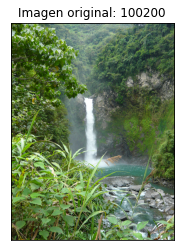

In [50]:
img_ex1 = mpimg.imread('jpg/' + img_query_ex1 + '.jpg')
plt.imshow(img_ex1)
plt.title('Imagen original: ' + img_query_ex1)
plt.xticks([]),plt.yticks([])
print('Pos. promedio similiares:', r)
print('Imágenes relevantes de la BBDD:', Nrel)
print('Pos. normalizada:', r_norm)

In [51]:
index_ex1 = dist_sort_euc_index[img_query_ex1] #posiciones de img cercanas
results = [index_ex1[i] for i in range(0,10)]
results_names = [db_names[pos] for pos in results] #nombres de img relevantes
results_img = [mpimg.imread('jpg/' + results_names[i] + '.jpg')
               for i in range(len(results_names))]
results_labels = ['Res. cercano ' + str(i+1)
                  + ': ' + results_names[i]
                  for i in range(len(results_names))]

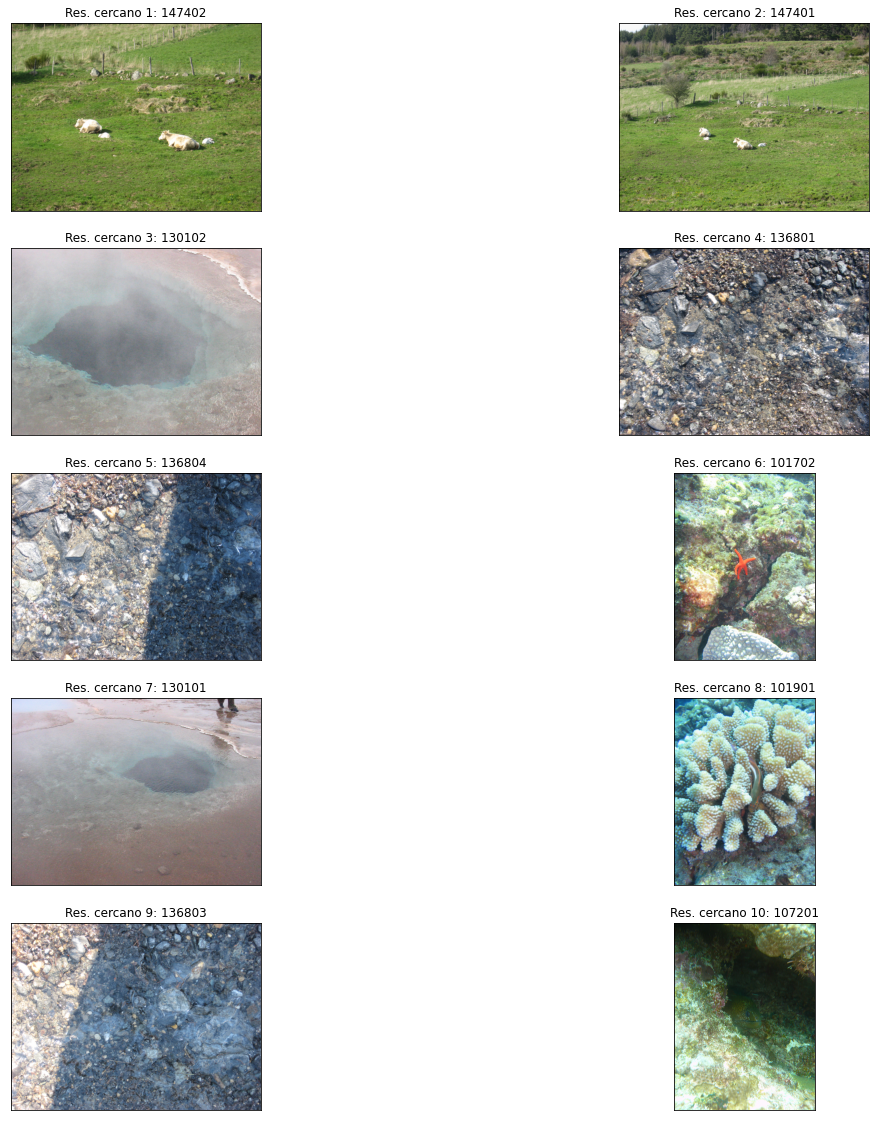

In [55]:
plt.figure(figsize = (20,20))
for i in range(len(results_img)):

    plt.subplot(5,2,i+1), plt.imshow(results_img[i])
    plt.title(results_labels[i])
    plt.xticks([]),plt.yticks([])

#### Ejemplo: extractor CNN, distancia euclideana

### 7. Optimización algorítmica del método

### Referencias utilizadas

[1] https://www.geeksforgeeks.org/chi-square-distance-in-python/

